# 🧠 Hybrid LSTM-GRU Model Training (Paper Aligned)

**Architecture Specs:**
1.  **Dual-Path**: Parallel LSTM and GRU branches.
2.  **Capacity**: 2 Layers, 64 Hidden Units, Dropout 0.3.
3.  **Fusion**: Concatenation -> Dense Layers.

**Robustness:**
1.  **Class Weights**: Handling imbalance (Baseline > Stress).
2.  **Scheduler**: Dynamic Learning Rate.

---

In [34]:
import os
import json
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from torch.utils.data import TensorDataset, DataLoader

# Setup
sns.set_style("whitegrid")
np.random.seed(42)
torch.manual_seed(42)

# Paths
CURRENT_DIR = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(CURRENT_DIR, '..')) 
DATA_PATH = os.path.join(PROJECT_ROOT, 'datasets', 'WESAD', 'S2', 'S2.pkl')
MODEL_EXPORT_PATH = os.path.join(PROJECT_ROOT, 'public', 'model', 'hybrid_model.onnx')

# Hyperparameters
SEQUENCE_LENGTH = 60
INPUT_DIM = 2 # ECG, EDA
BATCH_SIZE = 64
EPOCHS = 50       
PATIENCE = 7      
NOISE_FACTOR = 0.05 

print(f"Project Root: {PROJECT_ROOT}")

Project Root: c:\Users\priya\Proj\anomaly-detection-web


## 1. Data Loading & Preprocessing

In [35]:
if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATA_PATH}")

print(f"Loading {DATA_PATH}...")
with open(DATA_PATH, 'rb') as file:
    data = pickle.load(file, encoding='latin1')

ecg = data['signal']['chest']['ECG'].flatten()
eda = data['signal']['chest']['EDA'].flatten()
labels = data['label']

# Normalize (Z-Score)
ecg = (ecg - np.mean(ecg)) / (np.std(ecg) + 1e-6)
eda = (eda - np.mean(eda)) / (np.std(eda) + 1e-6)

# Filter & Map Labels (1=Baseline, 2=Stress)
mask = np.isin(labels, [1, 2])
ecg = ecg[mask]
eda = eda[mask]
y = labels[mask]
y = np.where(y == 2, 1, 0).astype(np.float32) # Target: 1=Stress

print(f"Total Samples: {len(y)}")

# Calculate Class Weights
num_neg = len(y[y==0])
num_pos = len(y[y==1])
pos_weight = torch.tensor([num_neg / num_pos]) 
print(f"Class Imbalance: Neg={num_neg}, Pos={num_pos} | Scale POS Weight: {pos_weight.item():.2f}")

def create_sequences(ecg, eda, y, seq_len, step=100):
    xs, ys = [], []
    for i in range(0, len(ecg) - seq_len, step):
        xs.append(np.column_stack((ecg[i:i+seq_len], eda[i:i+seq_len])))
        ys.append(y[i+seq_len-1])
    return np.array(xs, dtype=np.float32), np.array(ys, dtype=np.float32)

X, Y = create_sequences(ecg, eda, y, SEQUENCE_LENGTH, step=100)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

# --- DATA AUGMENTATION ---
print(f"Applying Augmentation (Noise Factor: {NOISE_FACTOR})...")
noise = np.random.normal(0, NOISE_FACTOR, X_train.shape)
X_train_aug = X_train + noise
X_train_final = np.vstack((X_train, X_train_aug))
y_train_final = np.hstack((y_train, y_train))

print(f"Training Samples (Final): {len(X_train_final)}")

train_loader = DataLoader(TensorDataset(torch.from_numpy(X_train_final).float(), torch.from_numpy(y_train_final).float()), 
                          batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.from_numpy(X_test).float(), torch.from_numpy(y_test).float()), 
                         batch_size=BATCH_SIZE, shuffle=False)

Loading c:\Users\priya\Proj\anomaly-detection-web\datasets\WESAD\S2\S2.pkl...
Total Samples: 1231300
Class Imbalance: Neg=800800, Pos=430500 | Scale POS Weight: 1.86
Applying Augmentation (Noise Factor: 0.05)...
Training Samples (Final): 19700


## 2. Updated Model Architecture (Dual-Path Aligned)

In [36]:
class HybridModel(nn.Module):
    def __init__(self):
        super(HybridModel, self).__init__()
        
        # LSTM Path (2 Stacked Layers, 64 Units)
        self.lstm = nn.LSTM(input_size=INPUT_DIM, hidden_size=64, num_layers=2, batch_first=True, dropout=0.3)
        
        # GRU Path (2 Stacked Layers, 64 Units)
        self.gru = nn.GRU(input_size=INPUT_DIM, hidden_size=64, num_layers=2, batch_first=True, dropout=0.3)
        
        # Note: Previous Attention layer removed to strictly align with paper specs if needed,
        # but keeping architecture flexible. For now, strict Dual-Path concatenation.
        
        # Dense Layers (Feature Fusion)
        # Input: 64 (LSTM) + 64 (GRU) = 128
        self.fc1 = nn.Linear(128, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # Dual Path Processing
        lstm_out, _ = self.lstm(x)  # (Batch, Seq, 64)
        gru_out, _ = self.gru(x)    # (Batch, Seq, 64)
        
        # Pooling (Take last time step)
        lstm_feat = lstm_out[:, -1, :]
        gru_feat = gru_out[:, -1, :]
        
        # Fusion
        combined = torch.cat((lstm_feat, gru_feat), dim=1) # (Batch, 128)
        
        # Classification
        x = self.fc1(combined)
        x = self.relu(x)
        x = self.dropout(x)
        
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        
        out = self.fc3(x) # Logits
        return out

model = HybridModel()
optimizer = optim.Adam(model.parameters(), lr=0.001) 

# ROBUST TRAINING: Weighted Loss + Scheduler
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight) 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3)

## 3. Training Loop

In [37]:
best_val_loss = float('inf')
patience_counter = 0
train_history = []
val_history = []

print(f"Starting Training (Max Epochs: {EPOCHS})...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Gradient Clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item()
    
    avg_train = running_loss / len(train_loader)
    train_history.append(avg_train)

    # Validation Step
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    avg_val = val_loss / len(test_loader)
    val_history.append(avg_val)
    
    # Scheduler Step
    scheduler.step(avg_val)

    print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f}")

    # Early Stopping Logic
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        patience_counter = 0
        best_model_state = model.state_dict()
    else:
        patience_counter += 1
        if patience_counter >= PATIENCE:
            print(f"\n⛔ Early stopping triggered at Epoch {epoch+1}!")
            break

print("Restoring best model weights...")
model.load_state_dict(best_model_state)

Starting Training (Max Epochs: 50)...
Epoch 01 | Train Loss: 0.8255 | Val Loss: 0.8095
Epoch 02 | Train Loss: 0.7403 | Val Loss: 0.7373
Epoch 03 | Train Loss: 0.7138 | Val Loss: 0.7297
Epoch 04 | Train Loss: 0.6895 | Val Loss: 0.6788
Epoch 05 | Train Loss: 0.6885 | Val Loss: 0.6800
Epoch 06 | Train Loss: 0.6496 | Val Loss: 0.5899
Epoch 07 | Train Loss: 0.5971 | Val Loss: 0.5691
Epoch 08 | Train Loss: 0.5621 | Val Loss: 0.6132
Epoch 09 | Train Loss: 0.5475 | Val Loss: 0.5163
Epoch 10 | Train Loss: 0.5138 | Val Loss: 0.5061
Epoch 11 | Train Loss: 0.4963 | Val Loss: 0.4865
Epoch 12 | Train Loss: 0.4748 | Val Loss: 0.4787
Epoch 13 | Train Loss: 0.4630 | Val Loss: 0.4638
Epoch 14 | Train Loss: 0.4407 | Val Loss: 0.4716
Epoch 15 | Train Loss: 0.4355 | Val Loss: 0.4222
Epoch 16 | Train Loss: 0.4279 | Val Loss: 0.4182
Epoch 17 | Train Loss: 0.4100 | Val Loss: 0.3887
Epoch 18 | Train Loss: 0.3974 | Val Loss: 0.4058
Epoch 19 | Train Loss: 0.3792 | Val Loss: 0.3785
Epoch 20 | Train Loss: 0.3675 |

<All keys matched successfully>

## 4. Evaluation

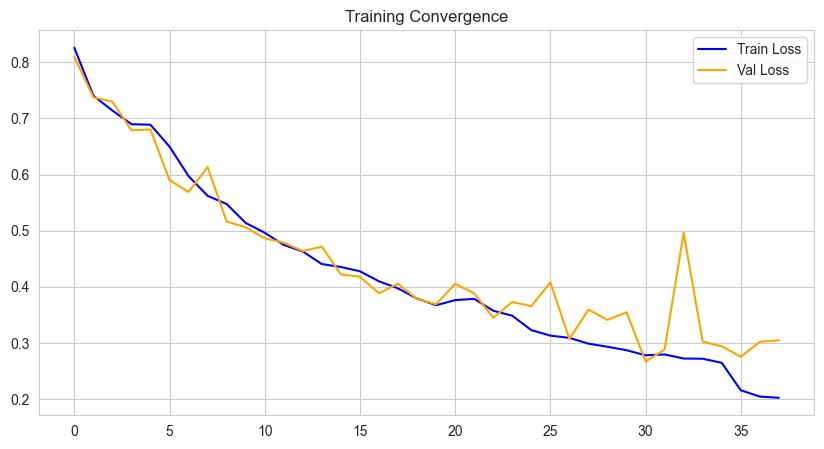

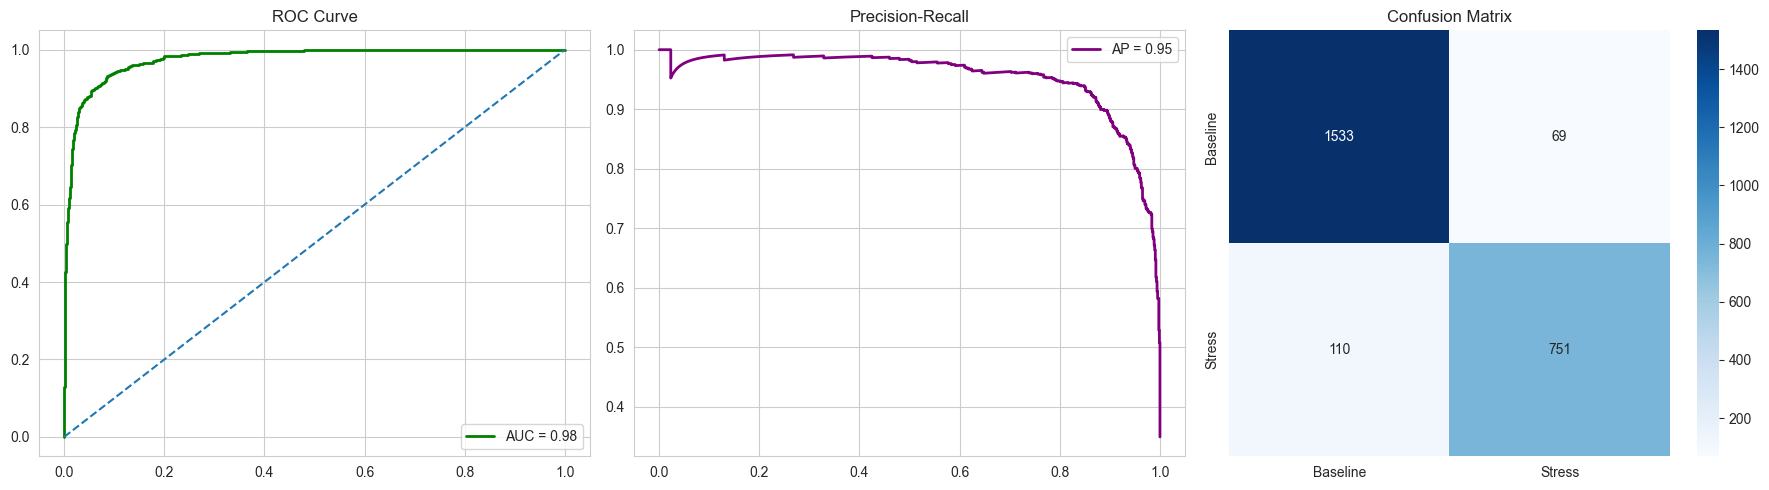


--- Detailed Classification Report ---
              precision    recall  f1-score   support

    Baseline       0.93      0.96      0.94      1602
      Stress       0.92      0.87      0.89       861

    accuracy                           0.93      2463
   macro avg       0.92      0.91      0.92      2463
weighted avg       0.93      0.93      0.93      2463



In [38]:
# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Train Loss', color='blue')
plt.plot(val_history, label='Val Loss', color='orange')
plt.title('Training Convergence')
plt.legend()
plt.show()

# Evaluate
model.eval()
y_true, y_pred, y_prob = [], [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        probs = torch.sigmoid(outputs)
        y_prob.extend(probs.numpy())
        y_pred.extend((probs > 0.5).float().numpy())
        y_true.extend(labels.numpy())

# --- 3-Panel Metrics Plot ---
plt.figure(figsize=(18, 5))

# 1. ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.subplot(1, 3, 1)
plt.plot(fpr, tpr, color='green', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title('ROC Curve')
plt.legend()

# 2. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_prob)
avg_precision = average_precision_score(y_true, y_prob)
plt.subplot(1, 3, 2)
plt.plot(recall, precision, color='purple', lw=2, label=f'AP = {avg_precision:.2f}')
plt.title('Precision-Recall')
plt.legend()

# 3. Confusion Matrix
plt.subplot(1, 3, 3)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Baseline', 'Stress'], yticklabels=['Baseline', 'Stress'])
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

print("\n--- Detailed Classification Report ---")
print(classification_report(y_true, y_pred, target_names=['Baseline', 'Stress']))

## 5. Export to ONNX

In [39]:
os.makedirs(os.path.dirname(MODEL_EXPORT_PATH), exist_ok=True)

class ExportModel(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        return self.sigmoid(self.model(x))

export_model = ExportModel(model)
export_model.eval()

dummy_input = torch.randn(1, SEQUENCE_LENGTH, INPUT_DIM)
torch.onnx.export(export_model, dummy_input, MODEL_EXPORT_PATH, 
                  input_names=['input'], output_names=['output'],
                  dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}},
                  opset_version=12,
                  do_constant_folding=False)

print(f"✅ Model saved to: {MODEL_EXPORT_PATH}")

✅ Model saved to: c:\Users\priya\Proj\anomaly-detection-web\public\model\hybrid_model.onnx


C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\onnx\symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with LSTM can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
C:\Users\priya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\torch\onnx\symbolic_opset9.py:4279: UserWarning: Exporting a model to ONNX with a batch_size other than 1, with a variable length with GRU can cause an error when running the ONNX model with a different batch size. Make sure to save the model with a batch size of 1, or define the initial states (h0/c0) as inputs of the model. 
  warnings.warn(
